In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FuncFormatter
import seaborn as sns

runs_dir = "runs-csv"

runs = {
    "task": [],
    "lr": [],
    "batch_size": [],
    "delay": [],
    "last_test_acc": [],
    "max_test_acc": []
}

for run_name in sorted(os.listdir(runs_dir)):
    task, lr, batch_size, delay = run_name.split("_")
    lr = float(lr)
    batch_size = int(batch_size)
    delay = int(delay)
    
    test_accs = []
    
    with open(os.path.join(runs_dir, run_name, "test_accuracy"), "r") as test_file:    
        for line in test_file:
            epoch, acc = line.split(",")
            epoch, acc = int(epoch), float(acc) / 100
            test_accs.append(acc)
        
    runs["task"].append(task)
    runs["lr"].append(lr)
    runs["batch_size"].append(batch_size)
    runs["delay"].append(delay)
    runs["last_test_acc"].append(test_accs[-1])
    runs["max_test_acc"].append(max(test_accs))

runs_df = pd.DataFrame.from_dict(runs)

In [2]:
def discrete_cmap(N, base_cmap=None, b=10):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.logspace(0, 1, N, base=b) / b)
#     color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

/home/ajay/.virtualenvs/optim/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Text(0.5,1,'Test accuracy after 30 epochs, with 1 batch delay')

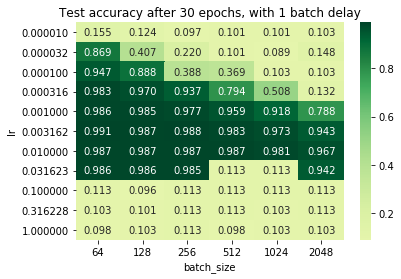

In [21]:
by_delay = []
for delay in range(4):
    by_delay.append(runs_df[runs_df["delay"] == delay])
    
delay = 1
selected_df = by_delay[delay][by_delay[delay].lr <= 1]
selected_df["lr"] = selected_df["lr"].map(lambda lr: "{:.6f}".format(lr))
pivoted = selected_df.pivot(index="lr", columns="batch_size", values="last_test_acc")

ax = sns.heatmap(pivoted, annot=True, cmap=discrete_cmap(999, "YlGn", 5), fmt=".3f")
ax.set_title("Test accuracy after 30 epochs, with {} batch delay".format(delay))


# ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.6e}"))
# ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.6e}"))
# ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: print(y, _)))
# ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.6e}"))

In [4]:
ax

In [5]:
selected_df["lr"].dtype

dtype('O')